<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Make-counterfactual-graph" data-toc-modified-id="Make-counterfactual-graph-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Make counterfactual graph</a></span></li>
    <li><span><a href="#Walkthrough-of-make-counterfactual-graph" data-toc-modified-id="Walkthrough-of-make-counterfactual-graph-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Walkthrough of make counterfactual graph</a></span></li>
    <ul>
    <li><span><a href="#Starting-graph-(Figure-9a)" data-toc-modified-id="Starting-graph-(Figure-9a)-3"><span class="toc-item-num">&nbsp;&nbsp;</span>Starting graph (Figure 9a)</a></span></li>
    <li><span><a href="#First-Step:-Make-Parallel-worlds-graph" data-toc-modified-id="First-Step:-Make-Parallel-worlds-graph-4"><span class="toc-item-num">&nbsp;&nbsp;</span>First Step: Make Parallel worlds graph</a></span></li>
    <li><span><a href="#Merging-the-Parallel-Worlds" data-toc-modified-id="Merging-the-Parallel-Worlds-5"><span class="toc-item-num">&nbsp;&nbsp;</span>Merging the Parallel Worlds</a></span></li>
    <li><span><a href="#Figure-11a-Checkpoint" data-toc-modified-id="Figure-11a-Checkpoint-6"><span class="toc-item-num">&nbsp;&nbsp;</span>Figure 11a Checkpoint</a></span></li>
    <li><span><a href="#Merging-nodes-with-different-parents" data-toc-modified-id="Merging-nodes-with-different-parents-7"><span class="toc-item-num">&nbsp;&nbsp;</span>Merging nodes with different parents</a></span></li>
    <li><span><a href="#Figure-11b-Checkpoint" data-toc-modified-id="Figure-11b-Checkpoint-8"><span class="toc-item-num">&nbsp;&nbsp;</span>Figure 11b Checkpoint</a></span></li>
    <li><span><a href="#Figure-11c-Checkpoint" data-toc-modified-id="Figure-11c-Checkpoint-9"><span class="toc-item-num">&nbsp;&nbsp;</span>Figure 11c Checkpoint</a></span></li>
    <li><span><a href="#Return-only-the-ancestors-of-events" data-toc-modified-id="Return only the ancestors of events-10"><span class="toc-item-num">&nbsp;&nbsp;</span>Return only the ancestors of events</a></span></li>
    <li><span><a href="#Figure-9c-Checkpoint" data-toc-modified-id="Figure-9c-Checkpoint-11"><span class="toc-item-num">&nbsp;&nbsp;</span>Figure 9c Checkpoint</a></span></li>
    </ul>
    <li><span><a href="#ID*-Algorithm" data-toc-modified-id="ID*-Algorithm"><span class="toc-item-num">3&nbsp;&nbsp;</span>ID* Algorithm</a></span></li>
    <li><span><a href="#ID*-Walkthrough" data-toc-modified-id="ID*-Walkthrough"><span class="toc-item-num">4&nbsp;&nbsp;</span>ID* Walkthrough</a></span></li>
    <ul>
    <li><span><a href="#ID*-lines-1-through-4" data-toc-modified-id="ID*-lines-1-through-4"><span class="toc-item-num">&nbsp;&nbsp;</span>ID* lines 1 through 4</a></span></li>
    <li><span><a href="#ID*-line-6,-calculate-the-C-components" data-toc-modified-id="ID*-line-6,-calculate-the-C-components"><span class="toc-item-num">&nbsp;&nbsp;</span>ID* line 6, calculate the C-components</a></span></li>
    <li><span><a href="#ID*-line-6,-get-the-markov-pillow-of-each-C-component" data-toc-modified-id="ID*-line-6,-get-the-markov-pillow-of-each-C-component"><span class="toc-item-num">&nbsp;&nbsp;</span>ID* line 6, get the markov pillow of each C-component</a></span></li>
    <li><span><a href="#Recursive-calls-for-each-C-component" data-toc-modified-id="Recursive-calls-for-each-C-component"><span class="toc-item-num">&nbsp;&nbsp;</span>Recursive calls for each C-component</a></span></li>
    </ul>
    </ul></div>

# Make counterfactual graph

$$\newcommand\ci{\perp\!\!\!\perp}$$
$$\newcommand{\ubar}[1]{\underset{\bar{}}{#1}}
\newcommand{\obar}[1]{\overset{\bar{}}{#1}}$$

**Lemma 24** Let $M$ be a model inducing $G$ containing variables $\alpha,\beta$ with the following properties: 
* $\alpha$ and $\beta$ have the same domain of values.
*  There is a bijection $f$ from $Pa(\alpha)$ to $Pa(\beta)$ such that a parent $\gamma$ and $f(\gamma)$ have the same domain of values. 
* The functional mechanisms of $\alpha$ and $\beta$ are the same (except whenever the function for $\alpha$ uses the parent $\gamma$, the corresponding function for $\beta$ uses $f (\gamma)$). 

Assume an observable variable set $\mathbf Z$ was observed to attain values $\mathbf{z}$ in $M_\mathbf{x}$, the submodel obtained from $M$ by forcing another observable variable set $\mathbf X$ to attain values $\mathbf x$. Assume further that for each $\gamma\in Pa(\alpha)$, either $f (\gamma) = \gamma$, or $\gamma$ and $f (\gamma)$ attain the same values (whether by observation or intervention). Then $\alpha$ and $\beta$ are the same random variable in $M_{\mathbf x}$ with observations $\mathbf z$.

$\textbf{Lemma 25}$. Let $M_\mathbf{x}$ be a submodel derived from $M$ with set $\mathbf Z$ observed to attain values $\mathbf z$, such that Lemma 24 holds for $\alpha, \beta$. Let $M'$ be a causal model obtained from $M$ by merging $\alpha, \beta$ into a new node $\omega$, which inherits all parents and the functional mechanism of $\alpha$. All children of $\alpha,\beta$ in $M'$ become children of $\omega$. Then $M_\mathbf{x}$,  $M'_\mathbf{x}$ agree on any distribution consistent with $\mathbf{z}$ being observed.



$\text{function }\mathbf{ make-cg}\left(G, \gamma\right) \\ \text{INPUT: } \text{ $G$ a causal diagram, $\gamma$ a conjunction of counterfactual events}. \\  \text{OUTPUT:  A counterfactual graph $G_\gamma$ and either a set of events $\gamma'$ such that $P(\gamma') = P(\gamma)$ or $\mathbf{Inconsistent}$} $

* Construct a submodel $G_{\mathbf{X}_i}$ for each action $do(\mathbf{x}_i)$ mentioned in $\gamma$. Construct the parallel worlds graph $G'$ by having all such graphs share their corresponding $U$ nodes.

* Let $\pi$ be a topological ordering of nodes in $G'$, let $\gamma':=\gamma.$
* Apply Lemmas 24 and 25, in order $\pi$ to each observable node pair $\alpha, \beta$ derived from the same variable in $G$. For each $\alpha, \beta$ that are the same, do:
    * Let $G'$ be modified as specified in Lemma 25
    * Modify $\gamma'$ by renaming all occurrences of $\beta$ to $\alpha$.
    * If $\mathbf{val}(\alpha)\neq \mathbf{val}(\beta)$, return $G', \mathbf{Inconsistent}$.
* $\texttt{return}$ $(G'_{An(\gamma')}, \gamma')$, where $An(\gamma')$ is the set of nodes in $G'$ ancestral to nodes corresponding to variables mentioned in $\gamma'$.

$$P(\lnot rxn_{do(\lnot catalyst)} | rxn, catalyst)$$

# Walkthrough of make counterfactual graph

In [5]:
%load_ext autoreload
%autoreload 2

from y0.algorithm.identify.cg import (
    make_parallel_worlds_graph,
    extract_interventions,
    make_counterfactual_graph,
    lemma_24_holds,
    is_pw_equivalent,
    has_same_function,
    # is_intervention_same_as_observed,
    merge_pw,
    is_inconsistent,
    update_event,
    parents_attain_same_values,
    is_not_self_intervened,
    value_of_self_intervention,
)
import networkx as nx
from y0.graph import NxMixedGraph
import importlib
from y0.algorithm.identify.id_star import get_events_of_district
from y0.algorithm.identify.idc_star import idc_star
from y0.graph import NxMixedGraph
from y0.examples import (
    figure_9a,
    figure_9b,
    figure_9c,
    figure_9d,
    figure_11a,
    figure_11b,
    figure_11c,
)
from y0.mutate.canonicalize_expr import canonicalize
from y0.dsl import (
    A,
    B,
    C,
    X,
    D,
    W,
    P,
    Y,
    Z,
    Event,
    CounterfactualVariable,
    Intervention,
    _get_treatment_variables,
    Variable,
    Zero,
)
from y0.algorithm.identify.id_star import (  # rule_3_applies,
    # get_district_interventions,
    get_events_of_district,
    get_events_of_each_district,
    get_free_variables,
    id_star,
    # id_star_line_4,
    id_star_line_6,
    id_star_line_9,
    get_cf_interventions,
    # intervene_on_district,
    # is_event_empty,
    get_evidence,
    is_redundant_counterfactual,
    # merge_interventions,
    remove_event_tautologies,
    # simplify_counterfactual,
    violates_axiom_of_effectiveness,
)
from y0.dsl import D, One, P, Sum, W, X, Y, Z, Zero
from y0.examples import (
    figure_9a,
    figure_9c,
    figure_9d,
    tikka_unidentifiable_graph,
    tikka_unidentifiable_cfgraph,
    tikka_figure_2,
    tikka_figure_5,
    tikka_figure_6a,
    tikka_figure_6b,
)
from y0.graph import NxMixedGraph
from y0.algorithm.identify.idc_star import (
    get_remaining_and_missing_events,
    get_new_outcomes_and_conditions,
)
from y0.examples import tikka_figure_2
from y0.algorithm.identify.cg import World
from y0.dsl import CounterfactualVariable
from y0.algorithm.identify.cg import extract_interventions, make_parallel_worlds_graph
from y0.algorithm.identify.id_star import id_star
from y0.dsl import _upgrade_ordering, _to_interventions
import matplotlib.pyplot as plt
from y0.dsl import Sum, P
from y0.algorithm.identify.id_star import id_star
from y0.algorithm.identify.idc_star import idc_star
from y0.examples import tikka_figure_2

from matplotlib_inline.backend_inline import set_matplotlib_formats
from IPython.display import Latex

set_matplotlib_formats("svg")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
x, y, z, w, d = -X, -Y, -Z, -W, -D

In [7]:
value_of_self_intervention(X @ -x)

-X

We illustrate the operation of make-cg by showing how the graph in Fig. 9 (c) is derived from the graph in Fig. 9 (a). We start the application of Lemma 24 from the topmost observable nodes, and conclude that the node pairs $D_x, D$, and $X_d, X$ have the same functional mechanisms, and the same parent set (in this case the parents are unobservable nodes $U_d$ for the first pair, and $U$ for the second). We then use Lemma 25 to obtain the graph shown in Fig. 11 (a). 
Since the node pairs are the same, we pick the name of one of the nodes of the pair to serve as the name of the new node. In our case, we picked D and X . Note that for this graph, and all subsequent intermediate graphs we generate, we use the convention that if a merge creates a situation where an unobservable variable has a single child, that variable is omitted from the graph. For instance, in Fig. 11 (a), the variable $U_d$ , and its corresponding arrow to $D$ omitted. 

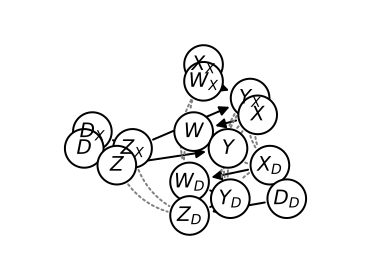

In [3]:
figure_9b.graph.draw()

# Starting graph (Figure 9a)

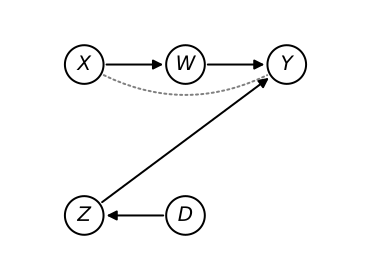

In [4]:
cf_graph_0 = figure_9a.graph
cf_graph_0.draw()

Every endogenous variable gets an exogenous variable, so there are some singletons pointing to the endogenous variables that don't have any bidirected edges.

<img src="images/factual-world.PNG" style="height: 400px" />


We have two interventions here, D and X are being intervened on.  

In [5]:
query = P(Y @ X | ~X, Z @ D, D)
query

P(Y @ -X | D, +X, Z @ -D)

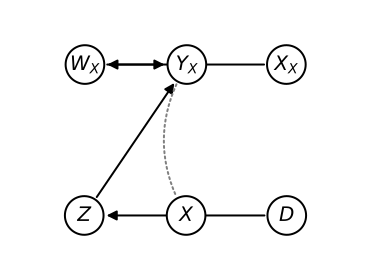

In [6]:
final_graph, event = make_counterfactual_graph(
    figure_9a.graph, {Y @ -x: -y, X: +x, Z @ -d: -z, D: -d}
)
final_graph.draw()

{Y @ -X: -Y, X: +X, D: -D, Y: -Y, Z: -Z}

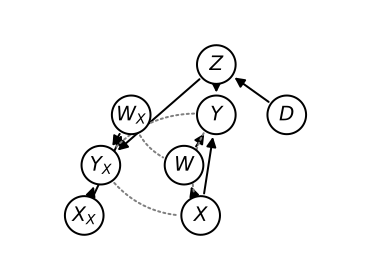

In [7]:
graph, event = make_counterfactual_graph(
    tikka_unidentifiable_graph.graph, {Y @ -x: -y, X: +x, Z @ -d: -z, D: -d, Y: -y}
)
graph.draw()
event

## First Step: Make Parallel worlds graph

Here we make a parallel worlds graph based on the interventions. Since we have two interventions we create two parallel worlds, represented here by different colors (red for the x intervention and green for the d intervention). The "parallel" variables in each world are connected by unidrected edges.

In [8]:
event = {Y @ -x: -y, X: +x, Z @ -d: -z, D: -d}  # This is the original event we are using
# the input for make_parallel_worlds_graph is a graph and extracted interventions from an event
cf_graph_1 = make_parallel_worlds_graph(figure_9a.graph, {frozenset([-x]), frozenset([-d])})

![Figure9B.PNG](images/parallel-worlds.png)


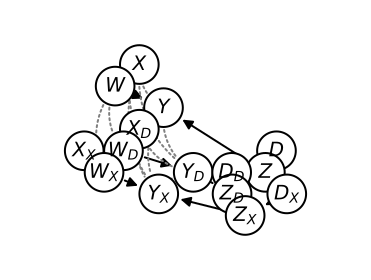

In [9]:
cf_graph_1.draw()

## Merging the Parallel Worlds

cf_graph_1 should be a stitched together graph of counterfactual worlds that corresponds to Figure 9b.
Now we will start merging nodes that are equivalent in the two graphs using the topological ordering of (X,D,W,Z,Y)

In [10]:
# Does Lemma 24 hold for X and X @ D?  Then Merge them together.
if lemma_24_holds(cf_graph_1, {Y @ -x: -y, D: -d, Z @ -d: -z, X: +x}, X, X @ D):
    cf_graph_2, preferred_node, eliminated_node = merge_pw(cf_graph_1, X, X @ D)
    # update the event
    new_event2 = update_event(event, preferred_node, eliminated_node)

### Next we merge `D` and `D @ ~x`

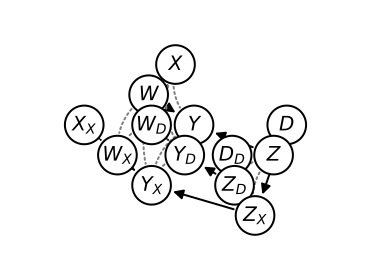

In [11]:
if lemma_24_holds(cf_graph_2, new_event2, D, D @ -x):
    cf_graph_3, preferred_node, eliminated_node = merge_pw(cf_graph_2, D, D @ -X)
    # update_event will be run after each merge_pw
    new_event3 = update_event(new_event2, preferred_node, eliminated_node)

    figure_11a_calculated = cf_graph_3
    figure_11a_calculated.draw()
else:
    print(f"{D} and {D @ -x} cannot be merged")

## Figure 11a Checkpoint

In [12]:
assert (
    figure_11a_calculated == figure_11a.graph
), "Calculated figure 11a is not equal to the actual figure 11a"
print("Figure 11a calculated is correct")

Figure 11a calculated is correct


![Figure11A.PNG](images/step-2-make-counterfactual.png)


## Merging nodes with different parents

We are allowed to merge certain nodes with different parents if the parents attain the same value. In our case we have `Z, Z @ -d`, and `Z @ -x` with parents `D` and `D @ -d` which attain the same values. This means that we can merge the three `Z` nodes. (notice that `D @ -d` disappears when we merge `Z, Z @ -d`)

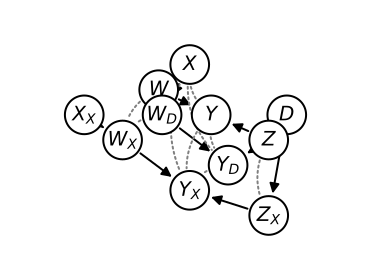

In [13]:
if lemma_24_holds(cf_graph_3, new_event3, Z, Z @ -d):
    cf_graph_4a, preferred_node, eliminated_node = merge_pw(cf_graph_3, Z, Z @ -d)
    # update the event
    new_event4a = update_event(new_event3, preferred_node, eliminated_node)
    cf_graph_4a.draw()
else:
    print(f"{Z} and {Z @ -d} cannot be merged")
if lemma_24_holds(cf_graph_4a, new_event4a, Z, Z @ -x):
    cf_graph_4b, preferred_node, eliminated_node = merge_pw(cf_graph_4a, Z, Z @ -x)
    # update the event
    new_event4b = update_event(new_event4a, preferred_node, eliminated_node)
else:
    print(f"{Z} and {Z @ -x} cannot be merged")

### Next we merge W and W @ D

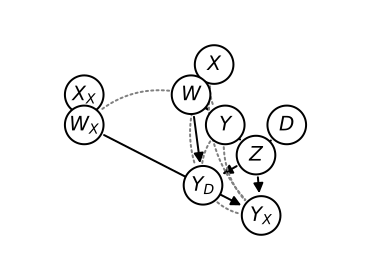

In [14]:
if lemma_24_holds(cf_graph_4b, new_event4b, W, W @ -d):
    cf_graph_5, preferred_node, eliminated_node = merge_pw(cf_graph_4b, W, W @ -d)
    # update the event
    new_event5 = update_event(new_event4b, preferred_node, eliminated_node)
    figure_11b_calculated = cf_graph_5
    figure_11b_calculated.draw()
else:
    print(f"{W} and {W @ -d} cannot be merged")

### Next we (attempt to) merge Y and Y @ X

In [15]:
if lemma_24_holds(cf_graph_5, new_event5, Y, Y @ -x):
    cf_graph_6, preferred_node, eliminated_node = merge_pw(cf_graph_5, Y, Y @ -x)
    # update the event
    new_event6 = update_event(new_event5, preferred_node, eliminated_node)
else:
    print(f"{Y} and {Y @ -x} cannot be merged")

Y and Y @ -X cannot be merged


## Figure 11b Checkpoint

In [16]:
assert (
    figure_11b_calculated == figure_11b.graph
), "Calculated figure 11b is not equal to the actual figure 11b"

print("Figure 11b calculated is correct")

Figure 11b calculated is correct


![Figure11B.PNG](images/step-4-make-counterfactual.PNG)

### Next, we (attempt to) merge `Y` and `Y @ -d`

None

{Y @ -X: -Y, X: +X, D: -D, Z: -Z}

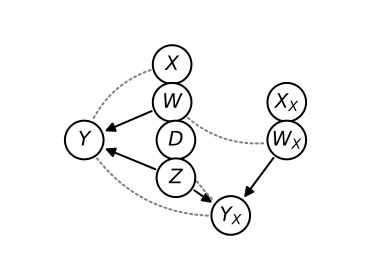

In [17]:
if lemma_24_holds(cf_graph_5, new_event5, Y, Y @ -d):
    cf_graph_7, preferred_node, eliminated_node = merge_pw(cf_graph_5, Y, Y @ -d)
    figure_11c_calculated = cf_graph_7
    # update the event
    new_event7 = update_event(new_event5, preferred_node, eliminated_node)
    display(figure_11c_calculated.draw())
    display(new_event7)
else:
    print(f"{Y} and {Y @ -d} cannot be merged")

![Figure11C.PNG](images/step-5-make-counterfactual.png)

## Figure 11c Checkpoint

In [18]:
assert (
    figure_11c_calculated == figure_11c.graph
), "Calculated figure 11c is not equal to the actual figure 11c"

print("Figure 11c calculated is correct")

Figure 11c calculated is correct


## Return only the ancestors of events

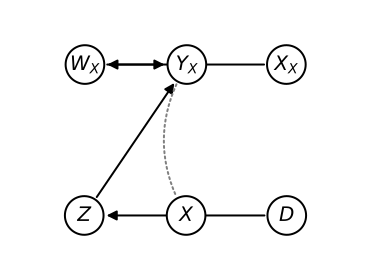

In [19]:
# this doesn't quite work yet but I will add it in soon
ancestors = cf_graph_7.ancestors_inclusive(new_event7)
return_graph = cf_graph_7.subgraph(ancestors)
figure_9c_calculated = return_graph
figure_9c_calculated.draw()

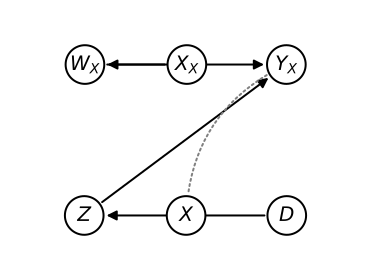

In [20]:
figure_9c.graph.draw()

The last line of `make-counterfactual-graph()` removes all nodes that are not ancestors of the events $\left\{y_{do(X=x')}, z, d\right\}$. Thus we remove $\{Y, W\}$

![Figure9C.PNG](images/counterfactual-graph.png)

## Figure 9c Checkpoint

In [21]:
assert (
    figure_9c_calculated == figure_9c.graph
), "Calculated figure 9c is not equal to the actual figure 9c"
print("Figure 9c calculated is correct")

Figure 9c calculated is correct



# ID* Algorithm

$\text{function }\mathbf{ ID^*}\left(G, \gamma\right) \\ \text{INPUT: } \text{ $G$ a causal diagram, $\gamma$ a conjunction of counterfactual events}. \\  \text{OUTPUT:  an expression for $P(\gamma)$ in terms of $P_*$ or $\mathbf{FAIL}$} $

* 1 if $\gamma=\varnothing$, return 1 
* 2 if ($\exists x_{x'..} \in \gamma$), return 0
* 3 if ($\exists x_{x..} \in \gamma$), return $\mathbf{ ID^*}(G,\gamma \backslash \{x_{x..}\})$
* 4 $(G',\gamma')=\mathbf{make-cg}(G,\gamma)$
* 5 if $\gamma'= \mathbf{INCONSISTENT}$ return 0
* 6 if $C(G')=\{S^1,...,S^k\},$ return $\sum_{\mathbf{V}(G')\backslash\gamma}\prod_{i}\mathbf{ID^*}(G,s^i_{\mathbf{v}(G')\backslash s^i})$
* 7 if $C(G')=\{S\}$ then
    * 8 if $\exists \mathbf{x,x'}$ s.t. $\mathbf{x} \neq \mathbf{x',x} \in \mathbf{sub}(S),\mathbf{x'} \in \mathbf{ev}(S),$ throw $\mathbf{FAIL}$
    * 9 else, let $\mathbf{x} = \bigcup \mathbf{sub}(S)$ return $P_\mathbf{x}(\mathbf{var}(S))$


In [22]:
event = {Y @ -x: -y, X: +x, Z @ -d: -z, D: -d}
expected = Sum[W](P(Y @ (-z, -w), X @ (-z, -w)) * P(Z @ -d) * P(W @ -x) * P(D))
expected = canonicalize(expected)
expected

Sum[W](P(D) * P(W @ -X) * P(X @ (-W, -Z), Y @ (-W, -Z)) * P(Z @ -D))

## ID* Walkthrough

We are going to start with the same graph that we started with for the make counterfactual graph walkthrough. 

![Figure9A.PNG](images/factual-world.PNG)


## ID* lines 1 through 4
On line 1 we check that the event is not empty. We move on to line 2 we note that $\gamma$ does not contain any inconsistencies. One line 3 we verify that $\gamma$ doesn't have any self interventions (if it does we will remove them from the query and run ID* on the new query). Finally on line 4 we run make-cg and obtain the counterfactual graph from before

Passed ID* line 1
Passed ID* line 2
Passed ID* line 3


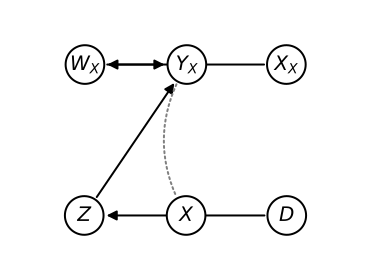

In [23]:
assert event is not None, "ID* line 1 failed, return One()"
print("Passed ID* line 1")

# Line 2: This violates the Axiom of Effectiveness
assert not violates_axiom_of_effectiveness(event), "ID* line 2 failed, return Zero()"
print("Passed ID* line 2")

# Line 3: This is a tautological event and can be removed without affecting the probability
reduced_event = remove_event_tautologies(event)
if reduced_event == event:
    print("Passed ID* line 3")
else:
    print("Reduction occurs on ID* line 3")

cf_graph, new_event = make_counterfactual_graph(figure_9a.graph, event)
cf_graph.draw()

![Figure9C.PNG](images/counterfactual-graph.png)

In [24]:
# We check that the new event $\gamma '$ is not inconsistent
assert new_event is not None, "ID* line 5 failed, return Zero()"
print("Passed ID* line 5")

Passed ID* line 5


## ID* line 6, calculate the C-components
$\text{Line 6 is only triggered if the counterfactual graph contains more than 1 C-component.} \\
\text{On line 6 we calculate the C-components of the counterfactual graph and then call ID* on each of these C-components.} \\
\text{We return the sum over the vertices which are in the counterfactual graph but not in the event times the product of a recursive call to ID* for each C-component.} \\
\text{The recursive call to ID* will have the original graph and new interventions, these interventions will be the markov pillow of the C-component}$

In [25]:
nodes = set(node for node in cf_graph.nodes() if is_not_self_intervened(node))
C_components = cf_graph.subgraph(nodes).get_c_components()

## ID* line 6, get the markov pillow of each C-component
$\text{For each C-component we will intervene on the nodes that are needed to infer the value of the C-componenet (Markov Pillow)} \\
$

In [26]:
for c_component in C_components:
    print(
        f"C-Component:{c_component} Interventions: {get_events_of_district(cf_graph,c_component,new_event)}"
    )

C-Component:frozenset({Y @ -X, X}) Interventions: {Y @ (-W, -Z): -Y, X @ (-W, -Z): +X}
C-Component:frozenset({Z}) Interventions: {Z @ -D: -Z}
C-Component:frozenset({W @ -X}) Interventions: {W @ -X: -W}
C-Component:frozenset({D}) Interventions: {D: -D}


## Recursive calls for each C-component
$\text{For each C-component there are no self interventions or empty events so we move past the first 5 lines.}\\
\text{ At line 6 we find in each case there is only 1 c-component, so we move to line 7 } \\
\text{ We find no conflicts on line 8 and return the probability on line 9}
$

In [27]:
for c_component in C_components:
    r_event = get_events_of_district(cf_graph, c_component, new_event)

    assert r_event is not None, "ID* line 1 failed, return One()"
    print("Passed ID* line 1")

    # Line 2: This violates the Axiom of Effectiveness
    assert not violates_axiom_of_effectiveness(r_event), "ID* line 2 failed, return Zero()"
    print("Passed ID* line 2")

    # Line 3: This is a tautological event and can be removed without affecting the probability
    reduced_event = remove_event_tautologies(r_event)
    if reduced_event == r_event:
        print("Passed ID* line 3")
    else:
        print("Reduction occurs on ID* line 3")

    r_cf_graph, r_new_event = make_counterfactual_graph(figure_9a.graph, r_event)

    assert r_new_event is not None, "ID* line 5 failed, return Zero()"
    print("Passed ID* line 5")
    nodes = set(node for node in r_cf_graph.nodes() if is_not_self_intervened(node))
    if r_cf_graph.subgraph(nodes).is_connected():
        print("Only 1 c-component, move past line 6")

    # Here is line 8.  We check for inconsistencies in the subscripts
    assert not any(
        intervention.name == evidence.name and intervention.star != evidence.star
        for intervention in get_cf_interventions(r_cf_graph.subgraph(nodes))
        for evidence in get_evidence(r_new_event)
    ), "ID* line 8 found inconsistencies, return Unidentifiable"
    print("Passed ID* line 8")

    # We have reached line 9, return the probability.
    if len(get_cf_interventions(r_cf_graph.subgraph(nodes))) > 0:
        print(
            "line 9 returns ",
            P[get_cf_interventions(r_cf_graph.subgraph(nodes))](node.get_base() for node in nodes),
        )
    else:
        print("line 9 returns ", P(node.get_base() for node in nodes))

Passed ID* line 1
Passed ID* line 2
Passed ID* line 3
Passed ID* line 5
Only 1 c-component, move past line 6
Passed ID* line 8
line 9 returns  P(X @ (-W, -Z), Y @ (-W, -Z))
Passed ID* line 1
Passed ID* line 2
Passed ID* line 3
Passed ID* line 5
Only 1 c-component, move past line 6
Passed ID* line 8
line 9 returns  P(Z @ -D)
Passed ID* line 1
Passed ID* line 2
Passed ID* line 3
Passed ID* line 5
Only 1 c-component, move past line 6
Passed ID* line 8
line 9 returns  P(W @ -X)
Passed ID* line 1
Passed ID* line 2
Passed ID* line 3
Passed ID* line 5
Only 1 c-component, move past line 6
Passed ID* line 8
line 9 returns  P(D)


In [28]:
actual = canonicalize(id_star(figure_9a.graph, event))
actual

Sum[W](P(D) * P(W @ -X) * P(X @ (-W, -Z), Y @ (-W, -Z)) * P(Z @ -D))

In [29]:
print(expected)
print(actual)
assert expected == actual, "expected was not equal to actual"
print("actual is equal to expected!!")

Sum[W](P(D) * P(W @ -X) * P(X @ (-W, -Z), Y @ (-W, -Z)) * P(Z @ -D))
Sum[W](P(D) * P(W @ -X) * P(X @ (-W, -Z), Y @ (-W, -Z)) * P(Z @ -D))
actual is equal to expected!!


# IDC* algorithm

The **IDC***, like its counterpart **IDC**, is shorter. 


The first line fails if $\gamma$ is inconsistent. **IDC** did not have an equivalent line, since we can assume $P(\mathbf{v})$ is positive. The problem with counterfactual distributions is there is no simple way to prevent non-positive distributions spanning multiple worlds from arising, even if the original P(v) was positive—hence the explicit check. 

1. if $\mathbf{ID*}(G,\delta)=0$, return **UNDEFINED**

The second line constructs the counterfactual graph, except since make-cg can only take conjunctions, we provide it with a joint counterfactual γ ^ δ. 

2. $(G',\gamma'\wedge\delta')=\mathbf{make-cg}(G,\gamma\wedge\delta)$

Line 3 returns 0 if an inconsistency was detected. 

3. if $\gamma'\wedge\delta' =$  **INCONSISTENT**, return $0$


Line 4 of **IDC*** is the central line of the algorithm and is analogous to line 1 of **IDC**. In **IDC**, we moved value assignment $Z = z$ from being observed to being fixed if there were no back-door paths from $Z$ to the outcome variables $\mathbf{Y}$ given the context of the effect of $do(\mathbf{x})$. Here in **IDC***, we move a counterfactual value assignment $Y_\mathbf{x} = y$ from being observed (that is being a part of $\delta$), to being fixed (that is appearing in every subscript of $\gamma'$) if there are no back-door paths from $Y_\mathbf{x}$ to the counterfactual of interest $\gamma'$.

$$\newcommand\ci{\perp\!\!\!\perp}$$
$$\newcommand{\ubar}[1]{\underset{\bar{}}{#1}}
\newcommand{\obar}[1]{\overset{\bar{}}{#1}}$$

4. if $(\exists y_\mathbf{x}\in\delta')$ s.t. $(Y_\mathbf{x} \ci \gamma')_{G'_{\ubar{y_\mathbf{x}}}}$, return $\mathbf{IDC^*}(G, \gamma'_{y_\mathbf{X}},\delta'\backslash\{y_{\mathbf{X}}\})$

Finally, line 5 of **IDC*** is the analogue of line 2 of **IDC**, we attempt to identify a joint counterfactual probability, and then obtain a conditional counterfactual probability from the result.

5. else, let $P'=\mathbf{ID^*}(G,\gamma'\wedge\delta')$. return $\frac{P'}{P'(\delta)}$

In [30]:
old_condition = {Y @ -x: -y, Y @ -z: +y}
new_condition = {Y: -y, Y @ -z: +y}
old_outcome = {Y @ -w: -y}
new_outcome = {Y: -y}
# P(Y: +y | +y)
new_outcome = {Y: -y}
remain_condition, missing_condition = get_remaining_and_missing_events(new_condition, old_condition)
remain_condition, missing_condition

({Y @ -Z: +Y}, {Y @ -X: -Y})

In [31]:
expected_new_outcomes_and_conditions = {Y: -y}, {Y: -y, Y @ -z: +y}

In [32]:
get_new_outcomes_and_conditions(
    new_event=new_outcome | new_condition, outcomes=old_outcome, conditions=old_condition
)

({Y: -Y}, {Y @ -Z: +Y, Y: -Y})

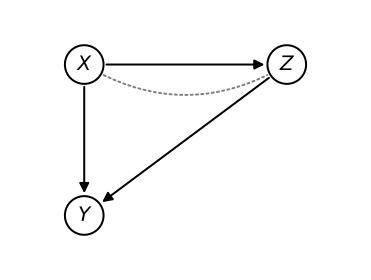

In [33]:
input_graph = tikka_figure_2.graph
input_graph.draw()

In [34]:
input_outcome = {Y @ -x: -y}
input_condition = {X: +x, Z @ -x: -z}
idc_star(input_graph, input_outcome, input_condition)

P(Y @ (-X, -Z))

In [35]:
variables = {Z @ -d}

variable = Z @ -d
isinstance(variable, CounterfactualVariable)
set(
    World(variable.interventions)
    for variable in variables
    if isinstance(variable, CounterfactualVariable)
)

{frozenset({-D})}

In [36]:
set(
    World(variable.interventions)
    for variable in variables
    if isinstance(variable, CounterfactualVariable)
)

{frozenset({-D})}

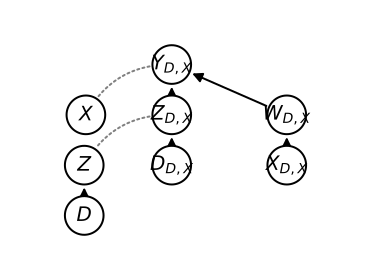

In [37]:
input_event5 = {Y @ (-D, -X): -Y, X: +X, Z: -Z}
graph5 = NxMixedGraph.from_edges(
    nodes=[Y @ (-D, -X), X, Z @ (-D, -X), Z, W @ (-D, -X), D @ (-D, -X), D, X @ (-D, -X)],
    directed=[
        (Z @ (-D, -X), Y @ (-D, -X)),
        (W @ (-D, -X), Y @ (-D, -X)),
        (D @ (-D, -X), Z @ (-D, -X)),
        (D, Z),
        (X @ (-D, -X), W @ (-D, -X)),
    ],
    undirected=[(Y @ (-D, -X), X), (Z @ (-D, -X), Z)],
)
district5 = {Z, Z @ (-D, -X)}
graph5.draw()

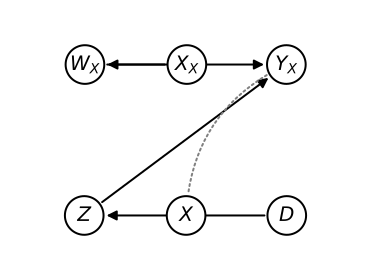

In [38]:
figure_9c.graph.draw()

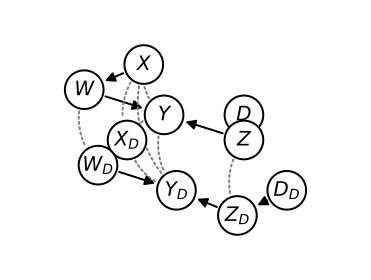

In [39]:
graph = figure_9a.graph
event = {X: +x, D: -d, Z @ -d: -z}
worlds = extract_interventions(event)
pw_graph = make_parallel_worlds_graph(graph, worlds)
new_event = dict(event)
cf_graph = NxMixedGraph.from_edges(
    nodes=pw_graph.nodes(),
    directed=pw_graph.directed.edges(),
    undirected=pw_graph.undirected.edges(),
)
pw_graph.draw()

In [40]:
worlds

{frozenset({-D})}

In [41]:
make_counterfactual_graph(figure_9a.graph, {X: +x, D: -d, Z @ -d: -z})

(NxMixedGraph(directed=<networkx.classes.digraph.DiGraph object at 0x125911420>, undirected=<networkx.classes.graph.Graph object at 0x125911360>),
 {X: +X, D: -D, Z: -Z})

In [42]:
id_star(figure_9a.graph, {Y @ -x: -y} | {X: +x, D: -d, Z @ -d: -z})

Sum[W](P(X @ (-W, -Z), Y @ (-W, -Z)) * P(Z @ -D) * P(W @ -X) * P(D))

In [43]:
idc_star(figure_9a.graph, {Y @ -x: -y}, {X: +x, D: -d, Z @ -d: -z})

((Sum[D, W](P(Z @ -D) * P(X @ (-W, -Z), Y @ (-W, -Z)) * P(W @ -X) * P(D)) / Sum[D, W, Y](Sum[D, W](P(Z @ -D) * P(X @ (-W, -Z), Y @ (-W, -Z)) * P(W @ -X) * P(D)))))

In [44]:
Z.intervene([D, D @ (-d, -x)])

Z @ -D

In [45]:
_upgrade_ordering([D, D @ (-d, -x)])

(D @ (-D, -X), D)

In [46]:
_to_interventions((D @ (-D, -X), D))

(-D, -D)

# Examples of Notation


In [47]:
W @ X

W @ -X

In [48]:
~W

+W

In [49]:
P(Y @ X | ~X, Z @ D, D)

P(Y @ -X | D, +X, Z @ -D)

In [50]:
{Y @ X: y}, {Y @ X: ~y}

({Y @ -X: -Y}, {Y @ -X: +Y})

In [51]:
P(+Y @ +X)

P(+Y @ +X)

In [52]:
P({Y @ +x: y})

P(Y @ +X)

# Examples of `make_counterfactual_graph`

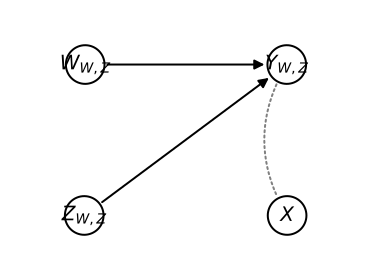

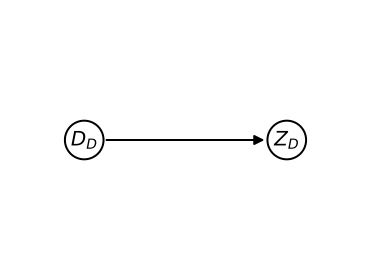

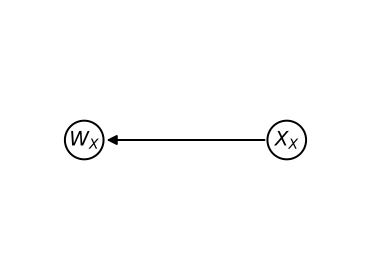

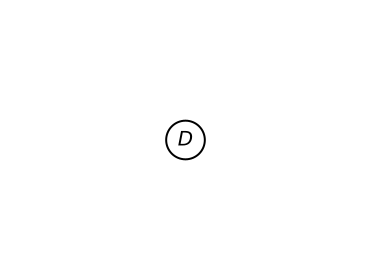

In [53]:
input_events = [{Y @ (-w, -z): -y, X @ (-w, -z): -x}, {Z @ -d: -z}, {W @ -x: -w}, {D: -d}]
for input_event in input_events:
    actual_graph, actual_event = make_counterfactual_graph(figure_9a.graph, input_event)
    actual_graph.draw()
    plt.show()

In [54]:
input_graph2 = figure_9a.graph
input_event2 = {Y @ -x: -y, X: +x, Z @ -d: -d, D: -d}
expected2 = Sum[W](P(Y @ (-z, -w), X @ (-z, -w)) * P(Z @ -d) * P(W @ -x) * P(D))
display(expected2)
display(id_star(input_graph2, input_event2))

Sum[W](P(X @ (-W, -Z), Y @ (-W, -Z)) * P(Z @ -D) * P(W @ -X) * P(D))

Sum[W, Z](P(X @ (-W, -Z), Y @ (-W, -Z)) * P(Z @ -D) * P(W @ -X) * P(D))

In [55]:
P(+Y | -y)

P(+Y | -Y)

In [56]:
str(idc_star(tikka_figure_2.graph, outcomes={Y @ -x: -y}, conditions={Z @ -x: -z, X: +x}))

'P(Y @ (-X, -Z))'

In [57]:
P(X, Y).conditional([])

((P(X, Y) / Sum[X, Y](P(X, Y))))

[X, W, Y, D, Z]
DiGraph with 5 nodes and 4 edges
MultiGraph with 5 nodes and 5 edges


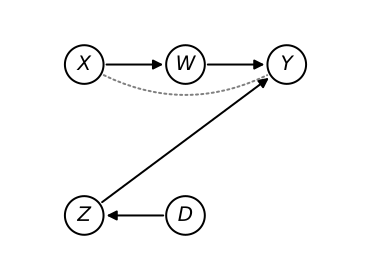

In [58]:
print(figure_9a.graph.nodes())
print(figure_9a.graph.directed)
print(figure_9a.graph.joint())
figure_9a.graph.draw()

# Counterfactual queries